In [ ]:
defungi_dataset_path = "/Code/Datasets/DeFungi"

In [1]:
import sys
import wget
import requests
import os
from PIL import Image, ImageDraw
from IPython.display import display
import torch
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import time
import numpy as np
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
sys.path.append('../../mae')
import models_mae
from models_mae import MaskedAutoencoderViT
from functools import partial
from sklearn.metrics import accuracy_score, recall_score, precision_score
%matplotlib inline
from tqdm.notebook import tqdm

In [2]:
from glob import glob
import os
import PIL.Image
import math
from torchvision.transforms.functional import pil_to_tensor


labels = ["H1", "H2", "H3", "H5", "H6"]

def load_defungi(path, sample_per_label = 400, training_percent = 0.8):
    if not os.path.isdir(path):
        raise Exception(f"{path} path does not exist")
    
    label_dict = {}

    for label in labels:
        label_dict[label] = []
        for file in glob(os.path.join(path, label, "*.jpg")):
            label_dict[label].append(PIL.Image.open(file))
    
    train_ds = []
    eval_ds = []
    train_count = math.floor(sample_per_label * training_percent)
    test_count = sample_per_label - train_count

    for label in labels:
        for i in range(train_count):
            if i < len(label_dict[label]):
                train_ds.append({"image": label_dict[label][i], "label": label, "y": labels.index(label)})
            else:
                print(f"Only {i} train samples for {label}")
                break

        for i in range(train_count, train_count + test_count):
            if i < len(label_dict[label]):
                eval_ds.append({"image": label_dict[label][i], "label": label, "y": labels.index(label)})
            else:
                print(f"Only {i} eval samples for {label}")
                break

    return pd.DataFrame(train_ds), pd.DataFrame(eval_ds)

train_df, eval_df = load_defungi(defungi_dataset_path)
display(train_df)
display(eval_df)

,image,label,y
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,H1,0
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,H1,0
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,H1,0
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,H1,0
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,H1,0
...,...,...,...
1595,<PIL.JpegImagePlugin.JpegImageFile image mode=...,H6,4
1596,<PIL.JpegImagePlugin.JpegImageFile image mode=...,H6,4
1597,<PIL.JpegImagePlugin.JpegImageFile image mode=...,H6,4
1598,<PIL.JpegImagePlugin.JpegImageFile image mode=...,H6,4


,image,label,y
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,H1,0
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,H1,0
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,H1,0
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,H1,0
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,H1,0
...,...,...,...
395,<PIL.JpegImagePlugin.JpegImageFile image mode=...,H6,4
396,<PIL.JpegImagePlugin.JpegImageFile image mode=...,H6,4
397,<PIL.JpegImagePlugin.JpegImageFile image mode=...,H6,4
398,<PIL.JpegImagePlugin.JpegImageFile image mode=...,H6,4


In [3]:
class DeFungiDataset(Dataset):
    def __init__(self, df):
        super().__init__()

        self.df = df

        self.y = df.iloc[:, 2]

        df = df.apply(lambda row: pil_to_tensor(row["image"]), axis=1)
        self.x = torch.stack(df.tolist(), dim=0)
        
        self.x = torch.tensor(self.x, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.long)

        self.x /= 255.0
        self.x = F.interpolate(self.x, size=(224, 224), mode='bilinear', antialias=True)
        print(self.y.shape)
        print(self.x.shape)
        
    def shape(self):
        return self.x.shape

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

eval_ds = DeFungiDataset(eval_df)
train_ds = DeFungiDataset(train_df)

/tmp/ipykernel_3671/2785889529.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(self.x, dtype=torch.float32)


torch.Size([400])
torch.Size([400, 3, 224, 224])
torch.Size([1600])
torch.Size([1600, 3, 224, 224])


array([[<Axes: title={'center': 'y'}>]], dtype=object)

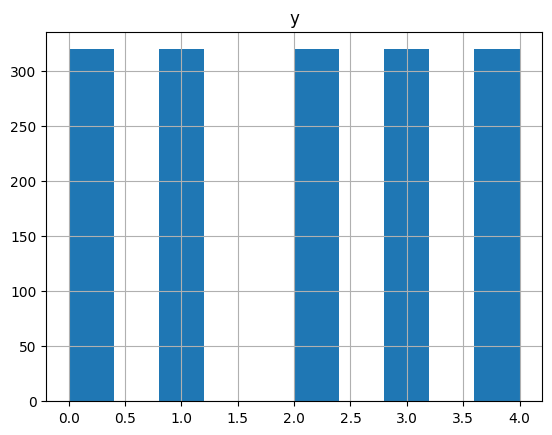

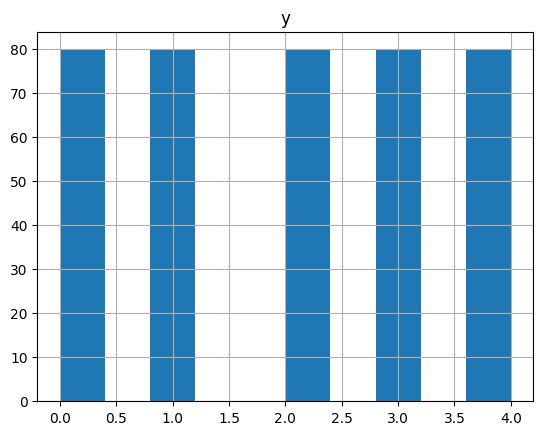

In [4]:
train_df.hist(column = 'y')
eval_df.hist(column = 'y')

In [5]:
train_loader = DataLoader(train_ds, batch_size=10, shuffle=True)
test_loader = DataLoader(eval_ds, batch_size=10, shuffle=False)

/tmp/ipykernel_3671/2785889529.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(self.x, dtype=torch.float32)


torch.Size([5])
torch.Size([5, 3, 224, 224])
torch.Size([5, 3, 224, 224])
    H1      H2      H3      H5      H6


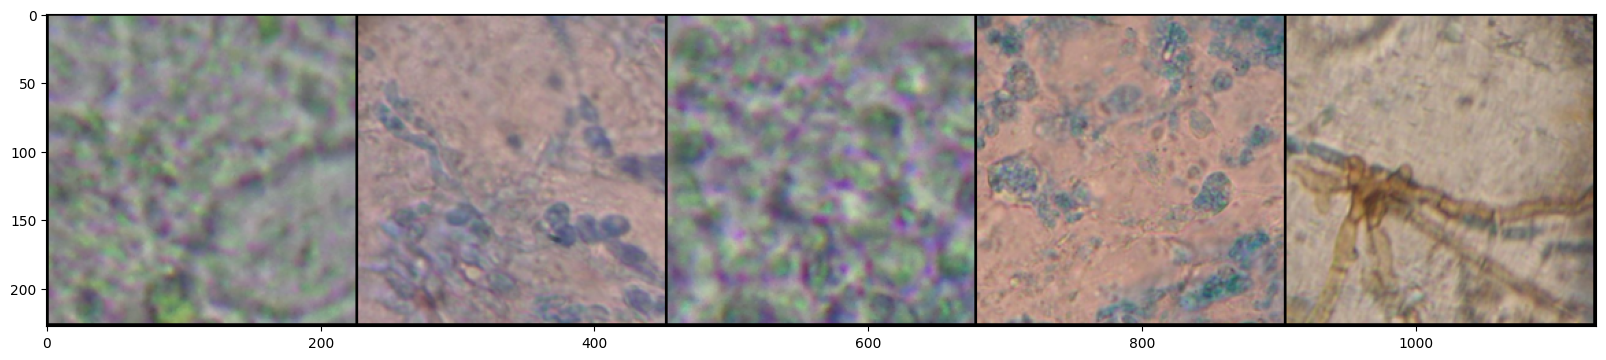

In [6]:
first_df = train_df.groupby('label', as_index=False).first()
first_dataset = DeFungiDataset(first_df)

images, l = first_dataset[:]
print(images.shape)

im = make_grid(images, nrow=len(first_df))
plt.figure(figsize=(20,8))
plt.imshow(np.transpose(im.numpy(),(1, 2, 0)))

labels_string = "      ".join(labels)
print("    " + labels_string)

In [7]:
# Defining the network architecture

class DeFungiModel(nn.Module):
    
    def __init__(self):       
        super().__init__()
        chkpt_dir = 'mae_visualize_vit_large.pth'
        model_mae = self.prepare_model(chkpt_dir)
        print('Model loaded.')
        
        self.backbone_model = model_mae      
        self.backbone_model.cuda()

        self.fc1 = nn.Linear(in_features=1024, out_features=len(labels))
        #self.fc2 = nn.Linear(in_features=512, out_features=128)
        #self.fc3 = nn.Linear(in_features=128, out_features=26)

    def forward(self, X):

        X = self.forward_ecoder(X, self.backbone_model)
        #X = F.relu(self.fc1(X))
        #X = F.relu(self.fc2(X))
        return F.log_softmax(input=self.fc1(X), dim=1)  
    
    def prepare_model(self, chkpt_dir):
        # build model
        model = MaskedAutoencoderViT(
            patch_size=16, img_size=224, embed_dim=1024, depth=24, num_heads=16,
            decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
            mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6))
        
        # load model
        checkpoint = torch.load(chkpt_dir, map_location='cuda')
        msg = model.load_state_dict(checkpoint['model'], strict=False)
        print(msg)
        for p in model.parameters():
            p.requires_grad = False 

        print(type(model))
        return model


    def forward_ecoder(self, x, model):
        # run MAE
        emb, mask, id = model.forward_encoder(x.float(), mask_ratio=0.75)
        return emb[:, 0, :]

In [8]:
# Training the model
epochs = 20

writer = SummaryWriter('DeFungiLog')

model = DeFungiModel()
model = model.cuda()

start_time = time.time()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []
accuracy_graph = []
precision_graph = []
recall_graph = [] 

for i in range(epochs):
    tst_corr = 0
    trn_corr = 0

    for b, (X_train, y_train) in tqdm(enumerate(train_loader)):
        b += 1
        X_train = X_train.cuda()
        y_train = y_train.cuda()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%28 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/{len(train_df)}]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
    
    writer.add_scalar("Loss/train", loss, i)     
    train_losses.append(loss.cpu().detach().numpy())

    # Test model per epoch
    model.eval()
    y_true_label = []
    predictions = []

    with torch.no_grad():
        for b, (X_test, y_test) in tqdm(enumerate(test_loader)):
            X_test = X_test.cuda()
            y_test = y_test.cuda()
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

            y_true_label.extend(y_test.cpu().detach().numpy())
            predictions.extend(predicted.cpu().detach().numpy())

    accuracy = accuracy_score(y_true_label, predictions)
    precision = precision_score(y_true_label, predictions, average="macro")
    recall = recall_score(y_true_label, predictions, average="macro")

    accuracy_graph.append(accuracy)
    precision_graph.append(precision)
    recall_graph.append(recall)
    
    writer.add_scalar("accuracy/test", tst_corr, i)
    model.train()

    loss = criterion(y_val,y_test)
    test_losses.append(loss.cpu().detach().numpy())
    print(f'test accuracy: {accuracy*100:7.2f}, precision: {precision*100:7.2f}, recall: {recall*100:7.2f}')
    torch.save(model.state_dict(), f"DeFungiEpoch/DeFungiModel_Epoch_{i}.pt")
    
total_time = time.time() - start_time
print(f'\nDuration: {total_time:.0f} seconds')

<All keys matched successfully>
<class 'models_mae.MaskedAutoencoderViT'>
Model loaded.


0it [00:00, ?it/s]

epoch:  0  batch:   28 [   280/1600]  loss: 1.46852040  accuracy:  33.571%
epoch:  0  batch:   56 [   560/1600]  loss: 1.50075138  accuracy:  36.964%
epoch:  0  batch:   84 [   840/1600]  loss: 1.38735139  accuracy:  41.071%
epoch:  0  batch:  112 [  1120/1600]  loss: 1.25606644  accuracy:  42.857%
epoch:  0  batch:  140 [  1400/1600]  loss: 1.37505925  accuracy:  45.571%


0it [00:00, ?it/s]

test accuracy:   45.75, precision:   42.69, recall:   45.75


0it [00:00, ?it/s]

epoch:  1  batch:   28 [   280/1600]  loss: 1.24701536  accuracy:  67.857%
epoch:  1  batch:   56 [   560/1600]  loss: 1.15874243  accuracy:  63.036%
epoch:  1  batch:   84 [   840/1600]  loss: 1.14798963  accuracy:  62.143%
epoch:  1  batch:  112 [  1120/1600]  loss: 1.10347748  accuracy:  60.893%
epoch:  1  batch:  140 [  1400/1600]  loss: 0.98206121  accuracy:  60.714%


0it [00:00, ?it/s]

test accuracy:   46.25, precision:   47.55, recall:   46.25


0it [00:00, ?it/s]

epoch:  2  batch:   28 [   280/1600]  loss: 1.01521087  accuracy:  61.786%
epoch:  2  batch:   56 [   560/1600]  loss: 1.05238271  accuracy:  63.929%
epoch:  2  batch:   84 [   840/1600]  loss: 1.19143176  accuracy:  64.048%
epoch:  2  batch:  112 [  1120/1600]  loss: 1.07612181  accuracy:  64.911%
epoch:  2  batch:  140 [  1400/1600]  loss: 1.22793722  accuracy:  64.214%


0it [00:00, ?it/s]

test accuracy:   45.75, precision:   44.60, recall:   45.75


0it [00:00, ?it/s]

epoch:  3  batch:   28 [   280/1600]  loss: 1.25694370  accuracy:  63.214%
epoch:  3  batch:   56 [   560/1600]  loss: 1.19759035  accuracy:  66.071%
epoch:  3  batch:   84 [   840/1600]  loss: 0.84823912  accuracy:  67.619%
epoch:  3  batch:  112 [  1120/1600]  loss: 1.09860826  accuracy:  70.179%
epoch:  3  batch:  140 [  1400/1600]  loss: 1.12385178  accuracy:  69.929%


0it [00:00, ?it/s]

test accuracy:   44.25, precision:   41.78, recall:   44.25


0it [00:00, ?it/s]

epoch:  4  batch:   28 [   280/1600]  loss: 1.24355066  accuracy:  64.643%
epoch:  4  batch:   56 [   560/1600]  loss: 1.30412102  accuracy:  67.321%
epoch:  4  batch:   84 [   840/1600]  loss: 0.96028221  accuracy:  67.619%
epoch:  4  batch:  112 [  1120/1600]  loss: 1.16767371  accuracy:  68.750%
epoch:  4  batch:  140 [  1400/1600]  loss: 1.02664018  accuracy:  69.857%


0it [00:00, ?it/s]

test accuracy:   47.00, precision:   45.68, recall:   47.00


0it [00:00, ?it/s]

epoch:  5  batch:   28 [   280/1600]  loss: 0.98759651  accuracy:  71.429%
epoch:  5  batch:   56 [   560/1600]  loss: 1.08923495  accuracy:  71.786%
epoch:  5  batch:   84 [   840/1600]  loss: 0.86853158  accuracy:  70.952%
epoch:  5  batch:  112 [  1120/1600]  loss: 1.36998868  accuracy:  71.250%
epoch:  5  batch:  140 [  1400/1600]  loss: 0.79093784  accuracy:  70.714%


0it [00:00, ?it/s]

test accuracy:   49.75, precision:   50.43, recall:   49.75


0it [00:00, ?it/s]

epoch:  6  batch:   28 [   280/1600]  loss: 1.09147668  accuracy:  72.143%
epoch:  6  batch:   56 [   560/1600]  loss: 0.68195611  accuracy:  73.214%
epoch:  6  batch:   84 [   840/1600]  loss: 1.06623852  accuracy:  73.690%
epoch:  6  batch:  112 [  1120/1600]  loss: 1.09536195  accuracy:  72.946%
epoch:  6  batch:  140 [  1400/1600]  loss: 0.70884973  accuracy:  72.571%


0it [00:00, ?it/s]

test accuracy:   51.25, precision:   49.75, recall:   51.25


0it [00:00, ?it/s]

epoch:  7  batch:   28 [   280/1600]  loss: 0.81438863  accuracy:  72.857%
epoch:  7  batch:   56 [   560/1600]  loss: 0.94039553  accuracy:  72.321%
epoch:  7  batch:   84 [   840/1600]  loss: 1.17920685  accuracy:  72.857%
epoch:  7  batch:  112 [  1120/1600]  loss: 0.59696090  accuracy:  72.946%
epoch:  7  batch:  140 [  1400/1600]  loss: 0.64863789  accuracy:  73.214%


0it [00:00, ?it/s]

test accuracy:   51.25, precision:   49.74, recall:   51.25


0it [00:00, ?it/s]

epoch:  8  batch:   28 [   280/1600]  loss: 0.94885349  accuracy:  70.357%
epoch:  8  batch:   56 [   560/1600]  loss: 0.64043790  accuracy:  70.893%
epoch:  8  batch:   84 [   840/1600]  loss: 0.98274803  accuracy:  72.024%
epoch:  8  batch:  112 [  1120/1600]  loss: 0.75636262  accuracy:  72.946%
epoch:  8  batch:  140 [  1400/1600]  loss: 0.59707868  accuracy:  73.071%


0it [00:00, ?it/s]

test accuracy:   54.00, precision:   52.93, recall:   54.00


0it [00:00, ?it/s]

epoch:  9  batch:   28 [   280/1600]  loss: 0.81934947  accuracy:  72.857%
epoch:  9  batch:   56 [   560/1600]  loss: 1.04094768  accuracy:  75.536%
epoch:  9  batch:   84 [   840/1600]  loss: 0.57504904  accuracy:  75.714%
epoch:  9  batch:  112 [  1120/1600]  loss: 0.73475730  accuracy:  75.804%
epoch:  9  batch:  140 [  1400/1600]  loss: 0.58173978  accuracy:  75.929%


0it [00:00, ?it/s]

test accuracy:   51.00, precision:   51.57, recall:   51.00


0it [00:00, ?it/s]

epoch: 10  batch:   28 [   280/1600]  loss: 0.75976968  accuracy:  73.214%
epoch: 10  batch:   56 [   560/1600]  loss: 0.52728981  accuracy:  74.464%
epoch: 10  batch:   84 [   840/1600]  loss: 0.91041166  accuracy:  75.119%
epoch: 10  batch:  112 [  1120/1600]  loss: 0.92510778  accuracy:  75.625%
epoch: 10  batch:  140 [  1400/1600]  loss: 0.47041449  accuracy:  76.571%


0it [00:00, ?it/s]

test accuracy:   49.25, precision:   49.50, recall:   49.25


0it [00:00, ?it/s]

epoch: 11  batch:   28 [   280/1600]  loss: 0.71663213  accuracy:  73.929%
epoch: 11  batch:   56 [   560/1600]  loss: 0.62423158  accuracy:  75.000%
epoch: 11  batch:   84 [   840/1600]  loss: 0.66016960  accuracy:  75.952%
epoch: 11  batch:  112 [  1120/1600]  loss: 0.86339551  accuracy:  75.982%
epoch: 11  batch:  140 [  1400/1600]  loss: 0.53936911  accuracy:  76.357%


0it [00:00, ?it/s]

test accuracy:   52.25, precision:   50.26, recall:   52.25


0it [00:00, ?it/s]

epoch: 12  batch:   28 [   280/1600]  loss: 0.70538992  accuracy:  75.714%
epoch: 12  batch:   56 [   560/1600]  loss: 0.88706744  accuracy:  76.250%
epoch: 12  batch:   84 [   840/1600]  loss: 0.62399852  accuracy:  76.190%
epoch: 12  batch:  112 [  1120/1600]  loss: 0.71441722  accuracy:  76.429%
epoch: 12  batch:  140 [  1400/1600]  loss: 0.30676323  accuracy:  76.929%


0it [00:00, ?it/s]

test accuracy:   48.50, precision:   49.06, recall:   48.50


0it [00:00, ?it/s]

epoch: 13  batch:   28 [   280/1600]  loss: 0.56455696  accuracy:  78.929%
epoch: 13  batch:   56 [   560/1600]  loss: 0.80897939  accuracy:  77.679%
epoch: 13  batch:   84 [   840/1600]  loss: 0.54755902  accuracy:  78.571%
epoch: 13  batch:  112 [  1120/1600]  loss: 0.63008213  accuracy:  79.107%
epoch: 13  batch:  140 [  1400/1600]  loss: 0.68269259  accuracy:  78.214%


0it [00:00, ?it/s]

test accuracy:   53.75, precision:   50.80, recall:   53.75


0it [00:00, ?it/s]

epoch: 14  batch:   28 [   280/1600]  loss: 0.66360718  accuracy:  75.000%
epoch: 14  batch:   56 [   560/1600]  loss: 0.78174043  accuracy:  76.964%
epoch: 14  batch:   84 [   840/1600]  loss: 0.82185364  accuracy:  77.976%
epoch: 14  batch:  112 [  1120/1600]  loss: 0.46449032  accuracy:  78.304%
epoch: 14  batch:  140 [  1400/1600]  loss: 0.75930244  accuracy:  78.714%


0it [00:00, ?it/s]

test accuracy:   50.75, precision:   48.52, recall:   50.75


0it [00:00, ?it/s]

epoch: 15  batch:   28 [   280/1600]  loss: 0.60374779  accuracy:  80.357%
epoch: 15  batch:   56 [   560/1600]  loss: 0.84350556  accuracy:  79.286%
epoch: 15  batch:   84 [   840/1600]  loss: 0.57043874  accuracy:  79.762%
epoch: 15  batch:  112 [  1120/1600]  loss: 1.04687381  accuracy:  78.036%
epoch: 15  batch:  140 [  1400/1600]  loss: 0.74558026  accuracy:  78.643%


0it [00:00, ?it/s]

test accuracy:   50.50, precision:   47.34, recall:   50.50


0it [00:00, ?it/s]

epoch: 16  batch:   28 [   280/1600]  loss: 0.63113320  accuracy:  77.857%
epoch: 16  batch:   56 [   560/1600]  loss: 0.60321486  accuracy:  77.679%
epoch: 16  batch:   84 [   840/1600]  loss: 0.57171839  accuracy:  78.214%
epoch: 16  batch:  112 [  1120/1600]  loss: 0.78722894  accuracy:  79.643%
epoch: 16  batch:  140 [  1400/1600]  loss: 0.68267590  accuracy:  80.143%


0it [00:00, ?it/s]

test accuracy:   51.50, precision:   54.12, recall:   51.50


0it [00:00, ?it/s]

epoch: 17  batch:   28 [   280/1600]  loss: 0.49248165  accuracy:  79.286%
epoch: 17  batch:   56 [   560/1600]  loss: 1.15073776  accuracy:  80.000%
epoch: 17  batch:   84 [   840/1600]  loss: 0.80837440  accuracy:  77.857%
epoch: 17  batch:  112 [  1120/1600]  loss: 0.59774780  accuracy:  78.750%
epoch: 17  batch:  140 [  1400/1600]  loss: 0.82152051  accuracy:  79.929%


0it [00:00, ?it/s]

test accuracy:   49.75, precision:   50.19, recall:   49.75


0it [00:00, ?it/s]

epoch: 18  batch:   28 [   280/1600]  loss: 0.37960637  accuracy:  83.214%
epoch: 18  batch:   56 [   560/1600]  loss: 0.58972877  accuracy:  80.179%
epoch: 18  batch:   84 [   840/1600]  loss: 0.83429545  accuracy:  79.643%
epoch: 18  batch:  112 [  1120/1600]  loss: 0.59962666  accuracy:  79.286%
epoch: 18  batch:  140 [  1400/1600]  loss: 0.64532501  accuracy:  79.214%


0it [00:00, ?it/s]

test accuracy:   52.00, precision:   49.28, recall:   52.00


0it [00:00, ?it/s]

epoch: 19  batch:   28 [   280/1600]  loss: 0.61298621  accuracy:  78.929%
epoch: 19  batch:   56 [   560/1600]  loss: 0.67710400  accuracy:  80.714%
epoch: 19  batch:   84 [   840/1600]  loss: 0.54204452  accuracy:  82.024%
epoch: 19  batch:  112 [  1120/1600]  loss: 0.36172506  accuracy:  80.893%
epoch: 19  batch:  140 [  1400/1600]  loss: 0.86789227  accuracy:  80.500%


0it [00:00, ?it/s]

test accuracy:   52.75, precision:   50.70, recall:   52.75

Duration: 793 seconds


In [9]:
model.load_state_dict(torch.load("DeFungiEpoch/DeFungiModel_Epoch_17.pt"))
model.eval()

test_load_all = DataLoader(eval_ds, batch_size=10000, shuffle=False)
with torch.no_grad():
    correct = 0
    for b, (X_test, y_test) in tqdm(enumerate(test_load_all)):
        y_val = model(X_test.cuda())
        predicted = torch.max(y_val.data, 1)[1]
        correct += (predicted == y_test.cuda()).sum()
print(f'Test Accuracy: {correct.item()/len(eval_df)*100:.2f}%')
predicted = predicted.cpu()

0it [00:00, ?it/s]

Test Accuracy: 52.50%


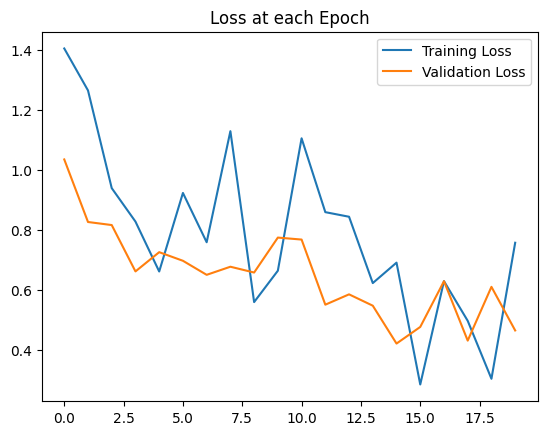

In [10]:
plt.plot(train_losses, label= 'Training Loss')
plt.plot(test_losses, label= 'Validation Loss')
plt.title('Loss at each Epoch')
plt.legend()

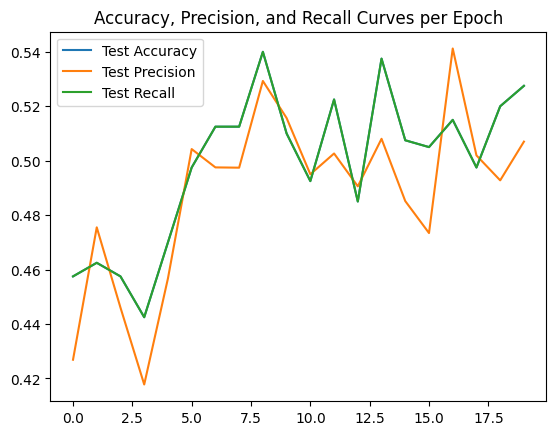

In [11]:
plt.plot(accuracy_graph, label="Test Accuracy")
plt.plot(precision_graph, label="Test Precision")
plt.plot(recall_graph, label="Test Recall")
plt.title('Accuracy, Precision, and Recall Curves per Epoch')
plt.legend()



['H1', 'H2', 'H3', 'H5', 'H6']
tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 3,
        1, 0, 0, 3, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 0, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1,
        1, 2, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
        1, 1, 1, 3, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 4, 3, 3, 3, 1, 1, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 1, 4, 4, 2, 1, 1, 1, 4,
        4, 4, 4, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 0, 0, 0, 2, 2, 2, 3,
        3, 3, 3, 3, 3, 4, 4, 4, 1, 1, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        2, 4, 4, 2, 2, 2, 4, 2, 4, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 4, 4,
        4, 4, 0, 4, 2, 4, 2, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 4, 1, 1,
        1

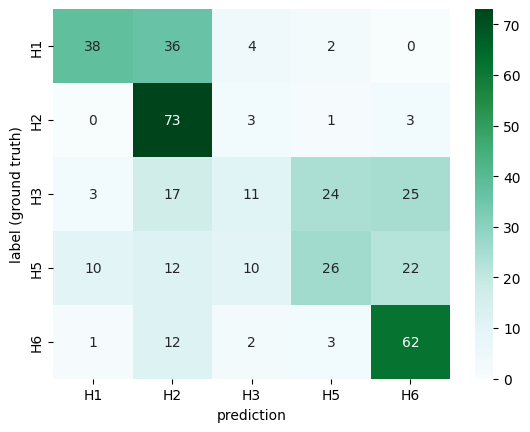

In [12]:
confusion_names = labels.copy()
print(confusion_names)
print(predicted)
arr = confusion_matrix(y_test.cpu().view(-1), predicted.cpu().view(-1))
df_cm = pd.DataFrame(arr, confusion_names, confusion_names)
plt.figure()
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [13]:
pred = labels.index('Textile Trash')
lbl = labels.index('Paper')
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] == pred and y_test[i] == lbl:
        misses = np.append(misses,i).astype('int64')
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}'))
r = 24
row = iter(np.array_split(misses,len(misses)//r+1))
nextrow = next(row)
lbls = y_test.index_select(0,torch.tensor(nextrow)).numpy()
gues = predicted.index_select(0,torch.tensor(nextrow)).numpy()
print("Index:", nextrow)
print("Label:", lbls)
print("Class: ", *np.array([labels[i] for i in lbls]))
print()
print("Guess:", gues)
print("Class: ", *np.array([labels[i] for i in gues]))

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(24,24))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))



ValueError: 'Textile Trash' is not in list

Index: [  280   282   283   284   285   287   288   289   290   291   293   299
   303]
Label: [    7     7     7     7     7     7     7     7     7     7     7     7
     7]
Class:  Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash

Guess: [    7     7     7     7     7     7     7     7     7     7     7     7
     7]
Class:  Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash


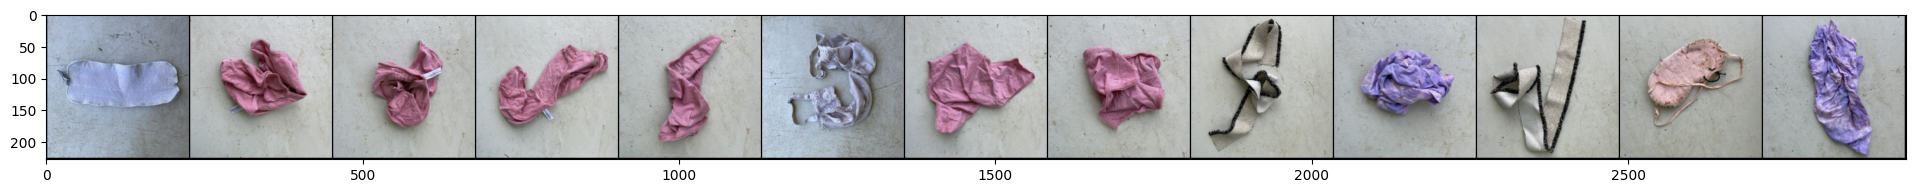

In [ ]:
pred = labels.index('Textile Trash')
lbl = labels.index('Textile Trash')
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] == pred and y_test[i] == lbl:
        misses = np.append(misses,i).astype('int64')
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}'))
r = 24
row = iter(np.array_split(misses,len(misses)//r+1))
nextrow = next(row)
lbls = y_test.index_select(0,torch.tensor(nextrow)).numpy()
gues = predicted.index_select(0,torch.tensor(nextrow)).numpy()
print("Index:", nextrow)
print("Label:", lbls)
print("Class: ", *np.array([labels[i] for i in lbls]))
print()
print("Guess:", gues)
print("Class: ", *np.array([labels[i] for i in gues]))

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(24,24))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))